In [3]:
import numpy as np
import pandas as pd
import nltk
from bs4 import BeautifulSoup
import re
import os
import codecs
from sklearn import feature_extraction
import mpld3

In [7]:
#import three lists: titles, links and wikipedia synopses
titles = open('title_list.txt').read().split('\n')
#ensures that only the first 100 are read in
titles = titles[:100]

links = open('link_list_imdb.txt').read().split('\n')
links = links[:100]

synopses_wiki = open('synopses_list_wiki.txt', encoding="utf8").read().split('\n BREAKS HERE')
synopses_wiki = synopses_wiki[:100]

synopses_clean_wiki = []
for text in synopses_wiki:
    text = BeautifulSoup(text, 'html.parser').getText()
    #strips html formatting and converts to unicode
    synopses_clean_wiki.append(text)

synopses_wiki = synopses_clean_wiki
    
    
genres = open('genres_list.txt').read().split('\n')
genres = genres[:100]

print(str(len(titles)) + ' titles')
print(str(len(links)) + ' links')
print(str(len(synopses_wiki)) + ' synopses')
print(str(len(genres)) + ' genres')

100 titles
100 links
100 synopses
100 genres


In [8]:
synopses_imdb = open('synopses_list_imdb.txt').read().split('\n BREAKS HERE')
synopses_imdb = synopses_imdb[:100]

synopses_clean_imdb = []

for text in synopses_imdb:
    text = BeautifulSoup(text, 'html.parser').getText()
    #strips html formatting and converts to unicode
    synopses_clean_imdb.append(text)

synopses_imdb = synopses_clean_imdb

In [9]:
synopses = []

for i in range(len(synopses_wiki)):
    item = synopses_wiki[i] + synopses_imdb[i]
    synopses.append(item)

In [10]:
# generates index for each item in the corpora (in this case it's just rank) and I'll use this for scoring later
ranks = []

for i in range(0,len(titles)):
    ranks.append(i)

In [11]:
# load nltk's English stopwords as variable called 'stopwords'
stopwords = nltk.corpus.stopwords.words('english')

In [14]:
# load nltk's SnowballStemmer as variabled 'stemmer'
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english")

In [15]:
# here I define a tokenizer and stemmer which returns the set of stems in the text that it is passed

def tokenize_and_stem(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems


def tokenize_only(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    return filtered_tokens

In [16]:
totalvocab_stemmed = []
totalvocab_tokenized = []
for i in synopses:
    allwords_stemmed = tokenize_and_stem(i)
    totalvocab_stemmed.extend(allwords_stemmed)
    
    allwords_tokenized = tokenize_only(i)
    totalvocab_tokenized.extend(allwords_tokenized)

In [17]:
vocab_frame = pd.DataFrame({'words': totalvocab_tokenized}, index = totalvocab_stemmed)

In [18]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=200000,
                                 min_df=0.2, stop_words='english',
                                 use_idf=True, tokenizer=tokenize_and_stem, ngram_range=(1,3))

%time tfidf_matrix = tfidf_vectorizer.fit_transform(synopses)

print(tfidf_matrix.shape)

Wall time: 8.84 s
(100, 563)


In [19]:
terms = tfidf_vectorizer.get_feature_names()

In [20]:
from sklearn.metrics.pairwise import cosine_similarity
dist = 1 - cosine_similarity(tfidf_matrix)

In [21]:
from sklearn.cluster import KMeans

num_clusters = 5

km = KMeans(n_clusters=num_clusters)

%time km.fit(tfidf_matrix)

clusters = km.labels_.tolist()

Wall time: 619 ms


In [22]:
from sklearn.externals import joblib

#joblib.dump(km,  'doc_cluster.pkl')
km = joblib.load('doc_cluster.pkl')
clusters = km.labels_.tolist()

C:\ProgramData\Anaconda3\envs\python36\lib\site-packages\sklearn\base.py:315: UserWarning: Trying to unpickle estimator KMeans from version pre-0.18 when using version 0.18.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\ProgramData\Anaconda3\envs\python36\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: The file 'doc_cluster.pkl' has been generated with a joblib version less than 0.10. Please regenerate this pickle file.
  after removing the cwd from sys.path.


In [23]:
import pandas as pd

films = { 'title': titles, 'rank': ranks, 'synopsis': synopses, 'cluster': clusters, 'genre': genres }

frame = pd.DataFrame(films, index = [clusters] , columns = ['rank', 'title', 'cluster', 'genre'])

In [24]:
frame['cluster'].value_counts()

4    26
0    25
2    21
1    16
3    12
Name: cluster, dtype: int64

In [25]:
grouped = frame['rank'].groupby(frame['cluster'])

grouped.mean()

cluster
0    47.200000
1    58.875000
2    49.380952
3    54.500000
4    43.730769
Name: rank, dtype: float64

In [26]:
from __future__ import print_function

print("Top terms per cluster:")
print()
order_centroids = km.cluster_centers_.argsort()[:, ::-1]
for i in range(num_clusters):
    print("Cluster %d words:" % i, end='')
    for ind in order_centroids[i, :6]:
        print(' %s' % vocab_frame.ix[terms[ind].split(' ')].values.tolist()[0][0].encode('utf-8', 'ignore'), end=',')
    print()
    print()
    print("Cluster %d titles:" % i, end='')
    for title in frame.ix[i]['title'].values.tolist():
        print(' %s,' % title, end='')
    print()
    print()

Top terms per cluster:

Cluster 0 words: b'family', b'home', b'mother', b'war', b'house', b'dies',

Cluster 0 titles: Schindler's List, One Flew Over the Cuckoo's Nest, Gone with the Wind, The Wizard of Oz, Titanic, Forrest Gump, E.T. the Extra-Terrestrial, The Silence of the Lambs, Gandhi, A Streetcar Named Desire, The Best Years of Our Lives, My Fair Lady, Ben-Hur, Doctor Zhivago, The Pianist, The Exorcist,

C:\ProgramData\Anaconda3\envs\python36\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  if __name__ == '__main__':
C:\ProgramData\Anaconda3\envs\python36\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  del sys.path[0]


 Out of Africa, Good Will Hunting, Terms of Endearment, Giant, The Grapes of Wrath, Close Encounters of the Third Kind, The Graduate, Stagecoach, Wuthering Heights,

Cluster 1 words: b'police', b'car', b'killed', b'murders', b'driving', b'house',

Cluster 1 titles: Casablanca, Psycho, Sunset Blvd., Vertigo, Chinatown, Amadeus, High Noon, The French Connection, Fargo, Pulp Fiction, The Maltese Falcon, A Clockwork Orange, Double Indemnity, Rebel Without a Cause, The Third Man, North by Northwest,

Cluster 2 words: b'father', b'new', b'york', b'new', b'brothers', b'apartments',

Cluster 2 titles: The Godfather, Raging Bull, Citizen Kane, The Godfather: Part II, On the Waterfront, 12 Angry Men, Rocky, To Kill a Mockingbird, Braveheart, The Good, the Bad and the Ugly, The Apartment, Goodfellas, City Lights, It Happened One Night, Midnight Cowboy, Mr. Smith Goes to Washington, Rain Man, Annie Hall, Network, Taxi Driver, Rear Window,

Cluster 3 words: b'george', b'dance', b'singing', b'john',

In [27]:
#This is purely to help export tables to html and to correct for my 0 start rank (so that Godfather is 1, not 0)
frame['Rank'] = frame['rank'] + 1
frame['Title'] = frame['title']

In [28]:
#export tables to HTML
print(frame[['Rank', 'Title']].loc[frame['cluster'] == 1].to_html(index=False))

<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th>Rank</th>
      <th>Title</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>5</td>
      <td>Casablanca</td>
    </tr>
    <tr>
      <td>13</td>
      <td>Psycho</td>
    </tr>
    <tr>
      <td>14</td>
      <td>Sunset Blvd.</td>
    </tr>
    <tr>
      <td>15</td>
      <td>Vertigo</td>
    </tr>
    <tr>
      <td>24</td>
      <td>Chinatown</td>
    </tr>
    <tr>
      <td>31</td>
      <td>Amadeus</td>
    </tr>
    <tr>
      <td>57</td>
      <td>High Noon</td>
    </tr>
    <tr>
      <td>64</td>
      <td>The French Connection</td>
    </tr>
    <tr>
      <td>77</td>
      <td>Fargo</td>
    </tr>
    <tr>
      <td>87</td>
      <td>Pulp Fiction</td>
    </tr>
    <tr>
      <td>91</td>
      <td>The Maltese Falcon</td>
    </tr>
    <tr>
      <td>92</td>
      <td>A Clockwork Orange</td>
    </tr>
    <tr>
      <td>95</td>
      <td>Double Indemnity</td>
    </tr>
    <tr

In [29]:
import os  # for os.path.basename

import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn.manifold import MDS

MDS()

# two components as we're plotting points in a two-dimensional plane
# "precomputed" because we provide a distance matrix
# we will also specify `random_state` so the plot is reproducible.
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)

pos = mds.fit_transform(dist)  # shape (n_components, n_samples)

xs, ys = pos[:, 0], pos[:, 1]

In [30]:
#strip any proper nouns (NNP) or plural proper nouns (NNPS) from a text
from nltk.tag import pos_tag

def strip_proppers_POS(text):
    tagged = pos_tag(text.split()) #use NLTK's part of speech tagger
    non_propernouns = [word for word,pos in tagged if pos != 'NNP' and pos != 'NNPS']
    return non_propernouns

In [31]:
#set up colors per clusters using a dict
cluster_colors = {0: '#1b9e77', 1: '#d95f02', 2: '#7570b3', 3: '#e7298a', 4: '#66a61e'}

#set up cluster names using a dict
cluster_names = {0: 'Family, home, war', 
                 1: 'Police, killed, murders', 
                 2: 'Father, New York, brothers', 
                 3: 'Dance, singing, love', 
                 4: 'Killed, soldiers, captain'}

In [32]:
%matplotlib inline

C:\ProgramData\Anaconda3\envs\python36\lib\site-packages\ipykernel_launcher.py:32: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix


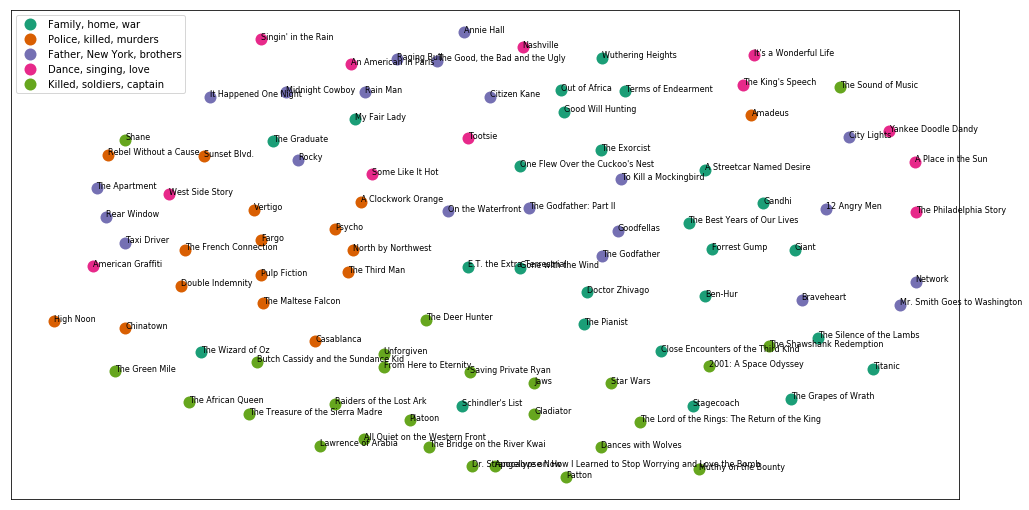

In [33]:
#create data frame that has the result of the MDS plus the cluster numbers and titles
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=titles)) 

#group by cluster
groups = df.groupby('label')


# set up plot
fig, ax = plt.subplots(figsize=(17, 9)) # set size
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

#iterate through groups to layer the plot
#note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, label=cluster_names[name], color=cluster_colors[name], mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='off')
    ax.tick_params(\
        axis= 'y',         # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelleft='off')
    
ax.legend(numpoints=1)  #show legend with only 1 point

#add label in x,y position with the label as the film title
for i in range(len(df)):
    ax.text(df.ix[i]['x'], df.ix[i]['y'], df.ix[i]['title'], size=8)  

    
    
plt.show() #show the plot

#uncomment the below to save the plot if need be
#plt.savefig('clusters_small_noaxes.png', dpi=200)

In [34]:
plt.close()

In [35]:
#define custom toolbar location
class TopToolbar(mpld3.plugins.PluginBase):
    """Plugin for moving toolbar to top of figure"""

    JAVASCRIPT = """
    mpld3.register_plugin("toptoolbar", TopToolbar);
    TopToolbar.prototype = Object.create(mpld3.Plugin.prototype);
    TopToolbar.prototype.constructor = TopToolbar;
    function TopToolbar(fig, props){
        mpld3.Plugin.call(this, fig, props);
    };

    TopToolbar.prototype.draw = function(){
      // the toolbar svg doesn't exist
      // yet, so first draw it
      this.fig.toolbar.draw();

      // then change the y position to be
      // at the top of the figure
      this.fig.toolbar.toolbar.attr("x", 150);
      this.fig.toolbar.toolbar.attr("y", 400);

      // then remove the draw function,
      // so that it is not called again
      this.fig.toolbar.draw = function() {}
    }
    """
    def __init__(self):
        self.dict_ = {"type": "toptoolbar"}

In [36]:
#create data frame that has the result of the MDS plus the cluster numbers and titles
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=titles)) 

#group by cluster
groups = df.groupby('label')

#define custom css to format the font and to remove the axis labeling
css = """
text.mpld3-text, div.mpld3-tooltip {
  font-family:Arial, Helvetica, sans-serif;
}

g.mpld3-xaxis, g.mpld3-yaxis {
display: none; }
"""

# Plot 
fig, ax = plt.subplots(figsize=(14,6)) #set plot size
ax.margins(0.03) # Optional, just adds 5% padding to the autoscaling

#iterate through groups to layer the plot
#note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in groups:
    points = ax.plot(group.x, group.y, marker='o', linestyle='', ms=18, label=cluster_names[name], mec='none', color=cluster_colors[name])
    ax.set_aspect('auto')
    labels = [i for i in group.title]
    
    #set tooltip using points, labels and the already defined 'css'
    tooltip = mpld3.plugins.PointHTMLTooltip(points[0], labels,
                                       voffset=10, hoffset=10, css=css)
    #connect tooltip to fig
    mpld3.plugins.connect(fig, tooltip, TopToolbar())    
    
    #set tick marks as blank
    ax.axes.get_xaxis().set_ticks([])
    ax.axes.get_yaxis().set_ticks([])
    
    #set axis as blank
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)

    
ax.legend(numpoints=1) #show legend with only one dot

mpld3.display() #show the plot

#uncomment the below to export to html
#html = mpld3.fig_to_html(fig)
#print(html)

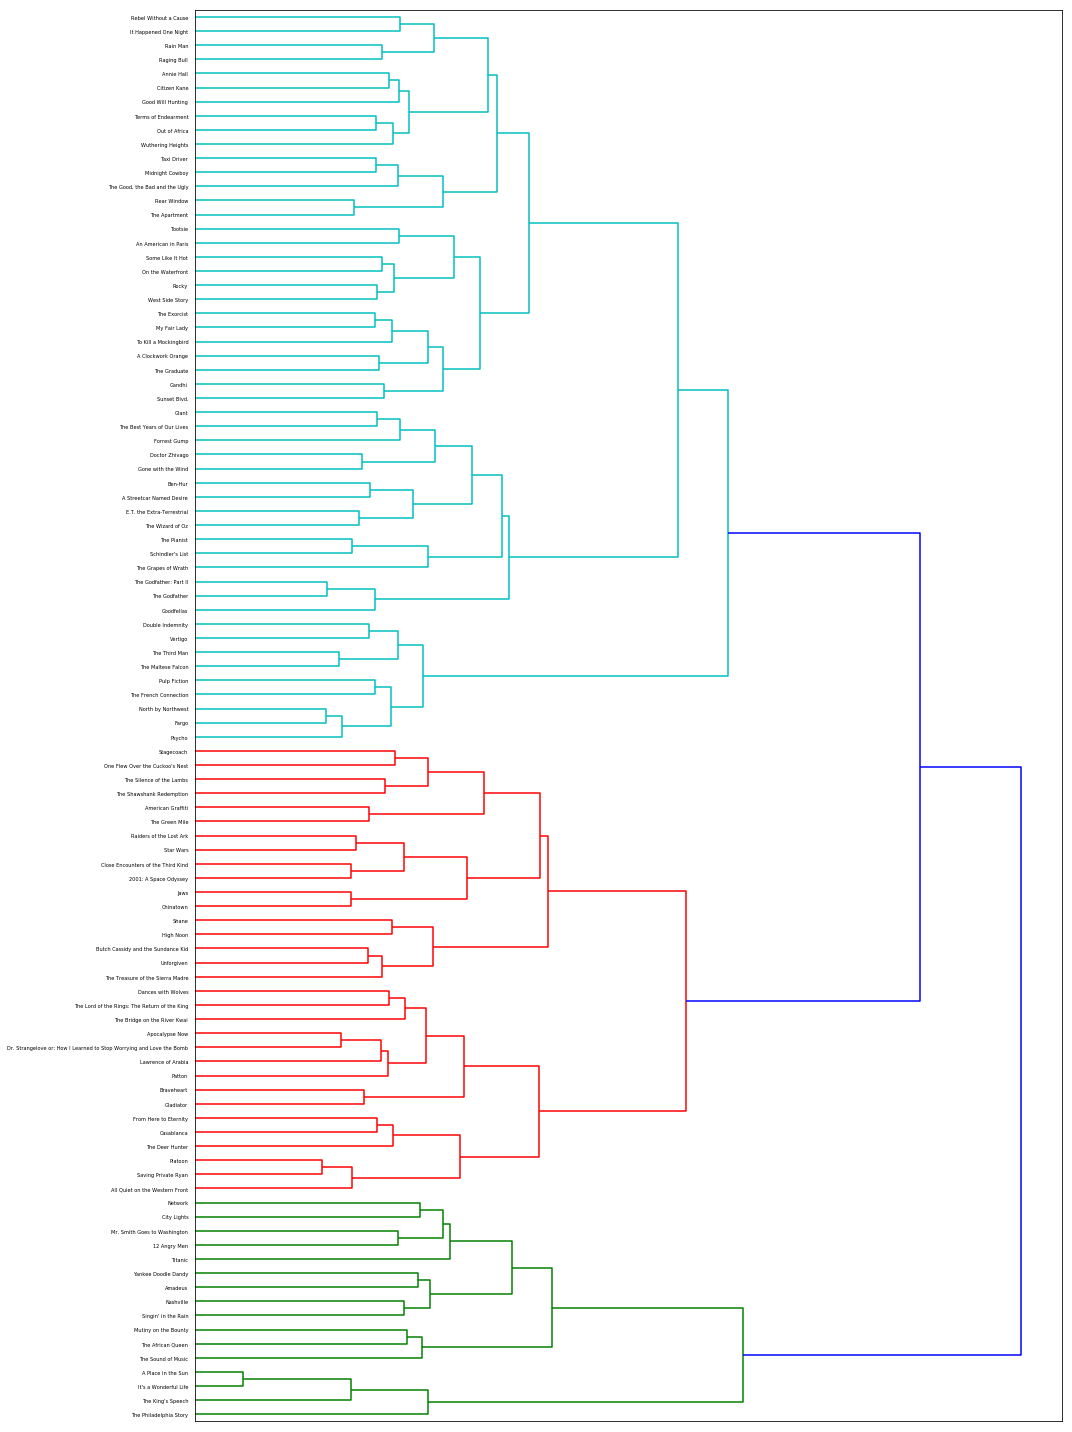

In [37]:
from scipy.cluster.hierarchy import ward, dendrogram

linkage_matrix = ward(dist) #define the linkage_matrix using ward clustering pre-computed distances

fig, ax = plt.subplots(figsize=(15, 20)) # set size
ax = dendrogram(linkage_matrix, orientation="right", labels=titles);

plt.tick_params(\
    axis= 'x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='off')

plt.tight_layout() #show plot with tight layout

#uncomment below to save figure
plt.savefig('ward_clusters.png', dpi=200) #save figure as ward_clusters

In [38]:
plt.close()

In [39]:
#strip any proper names from a text...unfortunately right now this is yanking the first word from a sentence too.
import string
def strip_proppers(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent) if word.islower()]
    return "".join([" "+i if not i.startswith("'") and i not in string.punctuation else i for i in tokens]).strip()

In [40]:
#strip any proper nouns (NNP) or plural proper nouns (NNPS) from a text
from nltk.tag import pos_tag

def strip_proppers_POS(text):
    tagged = pos_tag(text.split()) #use NLTK's part of speech tagger
    non_propernouns = [word for word,pos in tagged if pos != 'NNP' and pos != 'NNPS']
    return non_propernouns

In [41]:
#Latent Dirichlet Allocation implementation with Gensim

from gensim import corpora, models, similarities 

#remove proper names
preprocess = [strip_proppers(doc) for doc in synopses]

%time tokenized_text = [tokenize_and_stem(text) for text in preprocess]

%time texts = [[word for word in text if word not in stopwords] for text in tokenized_text]

C:\ProgramData\Anaconda3\envs\python36\lib\site-packages\gensim\utils.py:860: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


Wall time: 4.48 s
Wall time: 434 ms


In [42]:
#print(len([word for word in texts[0] if word not in stopwords]))
print(len(texts[0]))

1839


In [43]:
dictionary = corpora.Dictionary(texts)

In [44]:
dictionary.filter_extremes(no_below=1, no_above=0.8)

In [45]:
corpus = [dictionary.doc2bow(text) for text in texts]

In [46]:
len(corpus)

100

In [ ]:
%time lda = models.LdaModel(corpus, num_topics=5, id2word=dictionary, update_every=5, chunksize=10000, passes=100)

In [ ]:
print(lda[corpus[0]])

In [ ]:
topics = lda.print_topics(5, num_words=20)

In [ ]:
topics_matrix = lda.show_topics(formatted=False, num_words=20)

In [ ]:
topics_matrix = np.array(topics_matrix)

In [ ]:
topics_matrix.shape

In [ ]:
topic_words = topics_matrix[:,:,1]

In [ ]:
for i in topic_words:
    print([str(word) for word in i])
    print()